In [335]:
import numpy as np
import pandas as pd
from functools import cache

# Feature Engineering

In [336]:
batting_data = pd.read_parquet("data/batting_full.parquet.gz")
pitching_data = pd.read_parquet("data/pitching_full.parquet.gz")

In [337]:
# All 2024 Teams
teams = [
    "NYY",
    "KCR",
    "LAD",
    "BAL",
    "NYM",
    "BOS",
    "CLE",
    "CIN",
    "ARI",
    "TOR",
    "SFG",
    "MIL",
    "SEA",
    "HOU",
    "SDP",
    "PHI",
    "OAK",
    "ATL",
    "TEX",
    "MIN",
    "CHC",
    "DET",
    "COL",
    "STL",
    "PIT",
    "LAA",
    "WSN",
    "MIA",
    "TBR",
    "CHW",
]

In [338]:
# Drop teams that don't exist in 2024
batting_data = batting_data[batting_data["Team"].isin(teams)]
pitching_data = pitching_data[pitching_data["Team"].isin(teams)]

## Batting


In [339]:
batting_cols = [
    # Meta
    "IDfg",
    "Season",
    "Team",
    "Age",
    # Normalization
    "AB",
    # Stats
    "OPS",  # TODO: how to get OPS+?
    "WAR",
    "OBP+",
    "2B",
    "3B",
    "HR",
    "CS",
    "SB",
    "SO",
    # Left-handed?
]
batting_cleaned = batting_data[batting_cols].dropna()
batting_cleaned = batting_cleaned[batting_cleaned["AB"] > 0]
# Normalize for at-bats
for col in ["OPS", "2B", "3B", "HR", "SO", "CS", "SB"]:
    batting_cleaned[col] /= batting_cleaned["AB"]
batting_cleaned.rename(columns={"AB": "weight"}, inplace=True)

In [340]:
batting_cleaned.head()

,IDfg,Season,Team,Age,weight,OPS,WAR,OBP+,2B,3B,HR,CS,SB,SO
0,1008559,1998,STL,34,509,0.00,8.50,138.00,0.04,0.00,0.14,0.00,0.00,0.30
1,1109,1998,SFG,33,552,0.00,8.50,129.00,0.08,0.01,0.07,0.02,0.05,0.17
2,1093,1998,NYM,29,557,0.00,8.10,132.00,0.06,0.01,0.04,0.00,0.00,0.13
3,1274,1998,SEA,22,686,0.00,7.90,106.00,0.05,0.01,0.06,0.02,0.07,0.18
4,190,1998,BOS,24,604,0.00,7.30,106.00,0.06,0.01,0.06,0.01,0.02,0.10


In [341]:
# Save
batting_cleaned.to_parquet("data/batting_cleaned.parquet.gz", compression="gzip")

## Pitching


In [342]:
pitching_cols = [
    # Meta
    "IDfg",
    "Season",
    "Team",
    "Age",
    # Normalization
    "TBF",
    # Stats
    "ERA-",
    "H",
    "HR",
    "BB",
    "SO",
]

pitching_cleaned = pitching_data[pitching_cols].dropna()
pitching_cleaned = pitching_cleaned[pitching_cleaned["TBF"] > 0]
# Normalize for batters faced
for col in ["H", "HR", "BB", "SO"]:
    pitching_cleaned[col] /= pitching_cleaned["TBF"]
pitching_cleaned.rename(columns={"TBF": "weight"}, inplace=True)

In [343]:
pitching_cleaned.head()

,IDfg,Season,Team,Age,weight,ERA-,H,HR,BB,SO
0,642,1998,SDP,33,1032,60,0.22,0.01,0.05,0.25
1,73,1998,PHI,31,1089,76,0.22,0.02,0.06,0.28
2,815,1998,TOR,35,961,57,0.18,0.01,0.09,0.28
4,104,1998,ATL,32,987,53,0.20,0.01,0.05,0.21
5,200,1998,BOS,26,951,61,0.20,0.03,0.07,0.26


In [344]:
#  Save
pitching_cleaned.to_parquet("data/pitching_cleaned.parquet.gz", compression="gzip")

## Schedule/Record


In [345]:
schedules = pd.read_parquet("data/schedules_full.parquet.gz")

In [346]:
schedules.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Season
0,"Thursday, Mar 28",NYY,@,HOU,W,5.00,4.00,9.00,1-0,1.00,Tied,Loáisiga,Pressly,Holmes,2:41,D,42642.00,.93,1.00,None,2024
1,"Friday, Mar 29",NYY,@,HOU,W,7.00,1.00,9.00,2-0,1.00,up 0.5,Weaver,Scott,None,3:17,N,41583.00,.99,2.00,None,2024
2,"Saturday, Mar 30",NYY,@,HOU,W,5.00,3.00,9.00,3-0,1.00,up 0.5,Stroman,Abreu,Holmes,2:54,N,41247.00,1.05,3.00,None,2024
3,"Sunday, Mar 31",NYY,@,HOU,W,4.00,3.00,9.00,4-0,1.00,up 1.5,Burdi,Hader,Holmes,2:56,D,36908.00,1.06,4.00,None,2024
4,"Monday, Apr 1",NYY,@,ARI,W,5.00,2.00,9.00,5-0,1.00,up 1.5,Weaver,Nelson,González,2:59,N,38608.00,1.04,5.00,None,2024


In [347]:
schedules_cleaned = schedules[["Tm", "Opp", "W/L", "D/N", "Home_Away", "Season"]]
# Drop away games
schedules_cleaned = schedules_cleaned[schedules_cleaned["Home_Away"] == "Home"]
# Rename columns
schedules_cleaned.rename(columns={"Tm": "HomeTeam", "Opp": "AwayTeam"}, inplace=True)
# Add dummies
schedules_cleaned["Day"] = schedules_cleaned["D/N"].apply(
    lambda x: 1 if x == "D" else 0
)
schedules_cleaned["Win"] = schedules_cleaned["W/L"].apply(
    lambda x: 1 if x == "W" else 0
)
# Drop old columns
schedules_cleaned.drop(columns=["W/L", "D/N", "Home_Away"], inplace=True)


In [348]:
schedules_cleaned.head()

,HomeTeam,AwayTeam,Season,Day,Win
7,NYY,TOR,2024,1,0
8,NYY,TOR,2024,0,1
9,NYY,TOR,2024,1,1
10,NYY,MIA,2024,0,1
11,NYY,MIA,2024,0,1


In [349]:
# Save
schedules_cleaned.to_parquet("data/schedules_cleaned.parquet.gz", compression="gzip")

## Add Player Features to Schedules


In [350]:
schedules_cleaned.head()

,HomeTeam,AwayTeam,Season,Day,Win
7,NYY,TOR,2024,1,0
8,NYY,TOR,2024,0,1
9,NYY,TOR,2024,1,1
10,NYY,MIA,2024,0,1
11,NYY,MIA,2024,0,1


In [351]:
@cache
def get_players(Team, Season):
    batting = batting_cleaned[
        (batting_cleaned["Team"] == Team) & (batting_cleaned["Season"] == Season)
    ]["IDfg"].unique()
    pitching = pitching_cleaned[
        (pitching_cleaned["Team"] == Team) & (pitching_cleaned["Season"] == Season)
    ]["IDfg"].unique()
    return batting, pitching

In [352]:
@cache
def get_team_stats(Team, Season):
    batting_players, pitching_players = get_players(Team, Season)
    agg = {}

    # BATTING
    prior_season_batting = []
    batting_rookies = 0
    for player in batting_players:
        player_data = batting_cleaned[
            (batting_cleaned["IDfg"] == player)
            & (batting_cleaned["Team"] == Team)
            & (batting_cleaned["Season"] == Season - 1)
        ]
        if len(player_data) == 0:
            batting_rookies += 1
        else:
            prior_season_batting.append(player_data)
    batting_data = pd.concat(prior_season_batting)
    batting_data.drop(columns=["IDfg", "Season", "Team"], inplace=True)
    for col in batting_data.columns:
        if col == "weight":
            continue
        weights = batting_data["weight"].to_numpy()
        weighted_mean = np.average(batting_data[col], weights=weights)
        agg[f"batting_{col}_mean"] = weighted_mean
        # Bessel's correction for unbiased weighted sample variance
        agg[f"batting_{col}_var"] = np.sum(
            weights * (batting_data[col] - weighted_mean) ** 2
        ) / (np.sum(weights) - 1)
    agg["batting_rookies"] = batting_rookies

    # PITCHING
    prior_season_pitching = []
    pitching_rookies = 0
    for player in pitching_players:
        player_data = pitching_cleaned[
            (pitching_cleaned["IDfg"] == player)
            & (pitching_cleaned["Team"] == Team)
            & (pitching_cleaned["Season"] == Season - 1)
        ]
        if len(player_data) == 0:
            pitching_rookies += 1
        else:
            prior_season_pitching.append(player_data)
    pitching_data = pd.concat(prior_season_pitching)
    pitching_data.drop(columns=["IDfg", "Season", "Team"], inplace=True)
    for col in pitching_data.columns:
        if col == "weight":
            continue
        weights = pitching_data["weight"].to_numpy()
        weighted_mean = np.average(pitching_data[col], weights=weights)
        agg[f"pitching_{col}_mean"] = weighted_mean
        # Bessel's correction for unbiased weighted sample variance
        agg[f"pitching_{col}_var"] = np.sum(
            weights * (pitching_data[col] - weighted_mean) ** 2
        ) / (np.sum(weights) - 1)
    agg["pitching_rookies"] = pitching_rookies

    return agg


In [353]:
new_features = []
for i, row in schedules_cleaned.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    season = row["Season"]
    features = {}
    home_stats = get_team_stats(home_team, season)
    for key, value in home_stats.items():
        features[f"home_{key}"] = value
    away_stats = get_team_stats(away_team, season)
    for key, value in away_stats.items():
        features[f"away_{key}"] = value
    new_features.append(features)
new_features = pd.DataFrame(new_features)

In [354]:
final_data = pd.concat(
    [schedules_cleaned.reset_index(drop=True), new_features.reset_index(drop=True)],
    axis=1,
)

In [355]:
final_data.head()

,HomeTeam,AwayTeam,Season,Day,Win,home_batting_Age_mean,home_batting_Age_var,home_batting_OPS_mean,home_batting_OPS_var,home_batting_WAR_mean,home_batting_WAR_var,home_batting_OBP+_mean,home_batting_OBP+_var,home_batting_2B_mean,home_batting_2B_var,home_batting_3B_mean,home_batting_3B_var,home_batting_HR_mean,home_batting_HR_var,home_batting_CS_mean,home_batting_CS_var,home_batting_SB_mean,home_batting_SB_var,home_batting_SO_mean,home_batting_SO_var,home_batting_rookies,home_pitching_Age_mean,home_pitching_Age_var,home_pitching_ERA-_mean,home_pitching_ERA-_var,home_pitching_H_mean,home_pitching_H_var,home_pitching_HR_mean,home_pitching_HR_var,home_pitching_BB_mean,home_pitching_BB_var,home_pitching_SO_mean,home_pitching_SO_var,home_pitching_rookies,away_batting_Age_mean,away_batting_Age_var,away_batting_OPS_mean,away_batting_OPS_var,away_batting_WAR_mean,away_batting_WAR_var,away_batting_OBP+_mean,away_batting_OBP+_var,away_batting_2B_mean,away_batting_2B_var,away_batting_3B_mean,away_batting_3B_var,away_batting_HR_mean,away_batting_HR_var,away_batting_CS_mean,away_batting_CS_var,away_batting_SB_mean,away_batting_SB_var,away_batting_SO_mean,away_batting_SO_var,away_batting_rookies,away_pitching_Age_mean,away_pitching_Age_var,away_pitching_ERA-_mean,away_pitching_ERA-_var,away_pitching_H_mean,away_pitching_H_var,away_pitching_HR_mean,away_pitching_HR_var,away_pitching_BB_mean,away_pitching_BB_var,away_pitching_SO_mean,away_pitching_SO_var,away_pitching_rookies
0,NYY,TOR,2024,1,0,28.29,21.54,0.00,0.00,1.53,3.13,98.96,185.82,0.04,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.26,0.00,7,29.41,4.82,88.88,1013.03,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,14,26.55,11.76,0.00,0.00,2.17,0.92,104.20,72.04,0.05,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.20,0.00,8,30.33,8.37,87.35,602.83,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,9
1,NYY,TOR,2024,0,1,28.29,21.54,0.00,0.00,1.53,3.13,98.96,185.82,0.04,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.26,0.00,7,29.41,4.82,88.88,1013.03,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,14,26.55,11.76,0.00,0.00,2.17,0.92,104.20,72.04,0.05,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.20,0.00,8,30.33,8.37,87.35,602.83,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,9
2,NYY,TOR,2024,1,1,28.29,21.54,0.00,0.00,1.53,3.13,98.96,185.82,0.04,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.26,0.00,7,29.41,4.82,88.88,1013.03,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,14,26.55,11.76,0.00,0.00,2.17,0.92,104.20,72.04,0.05,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.20,0.00,8,30.33,8.37,87.35,602.83,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,9
3,NYY,MIA,2024,0,1,28.29,21.54,0.00,0.00,1.53,3.13,98.96,185.82,0.04,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.26,0.00,7,29.41,4.82,88.88,1013.03,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,14,26.13,5.52,0.00,0.00,0.69,0.45,90.55,113.58,0.05,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.26,0.00,12,24.80,0.16,81.84,83.99,0.21,0.00,0.03,0.00,0.08,0.00,0.26,0.00,24
4,NYY,MIA,2024,0,1,28.29,21.54,0.00,0.00,1.53,3.13,98.96,185.82,0.04,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.26,0.00,7,29.41,4.82,88.88,1013.03,0.21,0.00,0.03,0.00,0.08,0.00,0.25,0.00,14,26.13,5.52,0.00,0.00,0.69,0.45,90.55,113.58,0.05,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.26,0.00,12,24.80,0.16,81.84,83.99,0.21,0.00,0.03,0.00,0.08,0.00,0.26,0.00,24


In [356]:
# Save
final_data.to_parquet("data/final_data.parquet.gz", compression="gzip")

# Model Selection + Training

In [357]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300

In [366]:
def best_accuracy(y_true, y_prob):
    best_acc = 0
    best_threshold = 0
    for threshold in np.linspace(0, 1, 100):
        y_pred = y_prob > threshold
        acc = accuracy_score(y_true, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    return best_acc

In [358]:
X = final_data.drop(columns=["HomeTeam", "AwayTeam", "Season", "Win"]).copy()
y = final_data.Win

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [360]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


In [361]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.54,0.55,0.55,0.54,6.22
NearestCentroid,0.54,0.54,0.54,0.55,0.02
Perceptron,0.54,0.54,0.54,0.54,0.05
SGDClassifier,0.54,0.53,0.53,0.55,0.19
BernoulliNB,0.55,0.53,0.53,0.55,0.25
GaussianNB,0.55,0.53,0.53,0.55,0.03
PassiveAggressiveClassifier,0.52,0.53,0.53,0.52,0.07
LinearSVC,0.56,0.53,0.53,0.55,1.06
RidgeClassifier,0.56,0.52,0.52,0.55,0.38


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_error: 0.399177


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

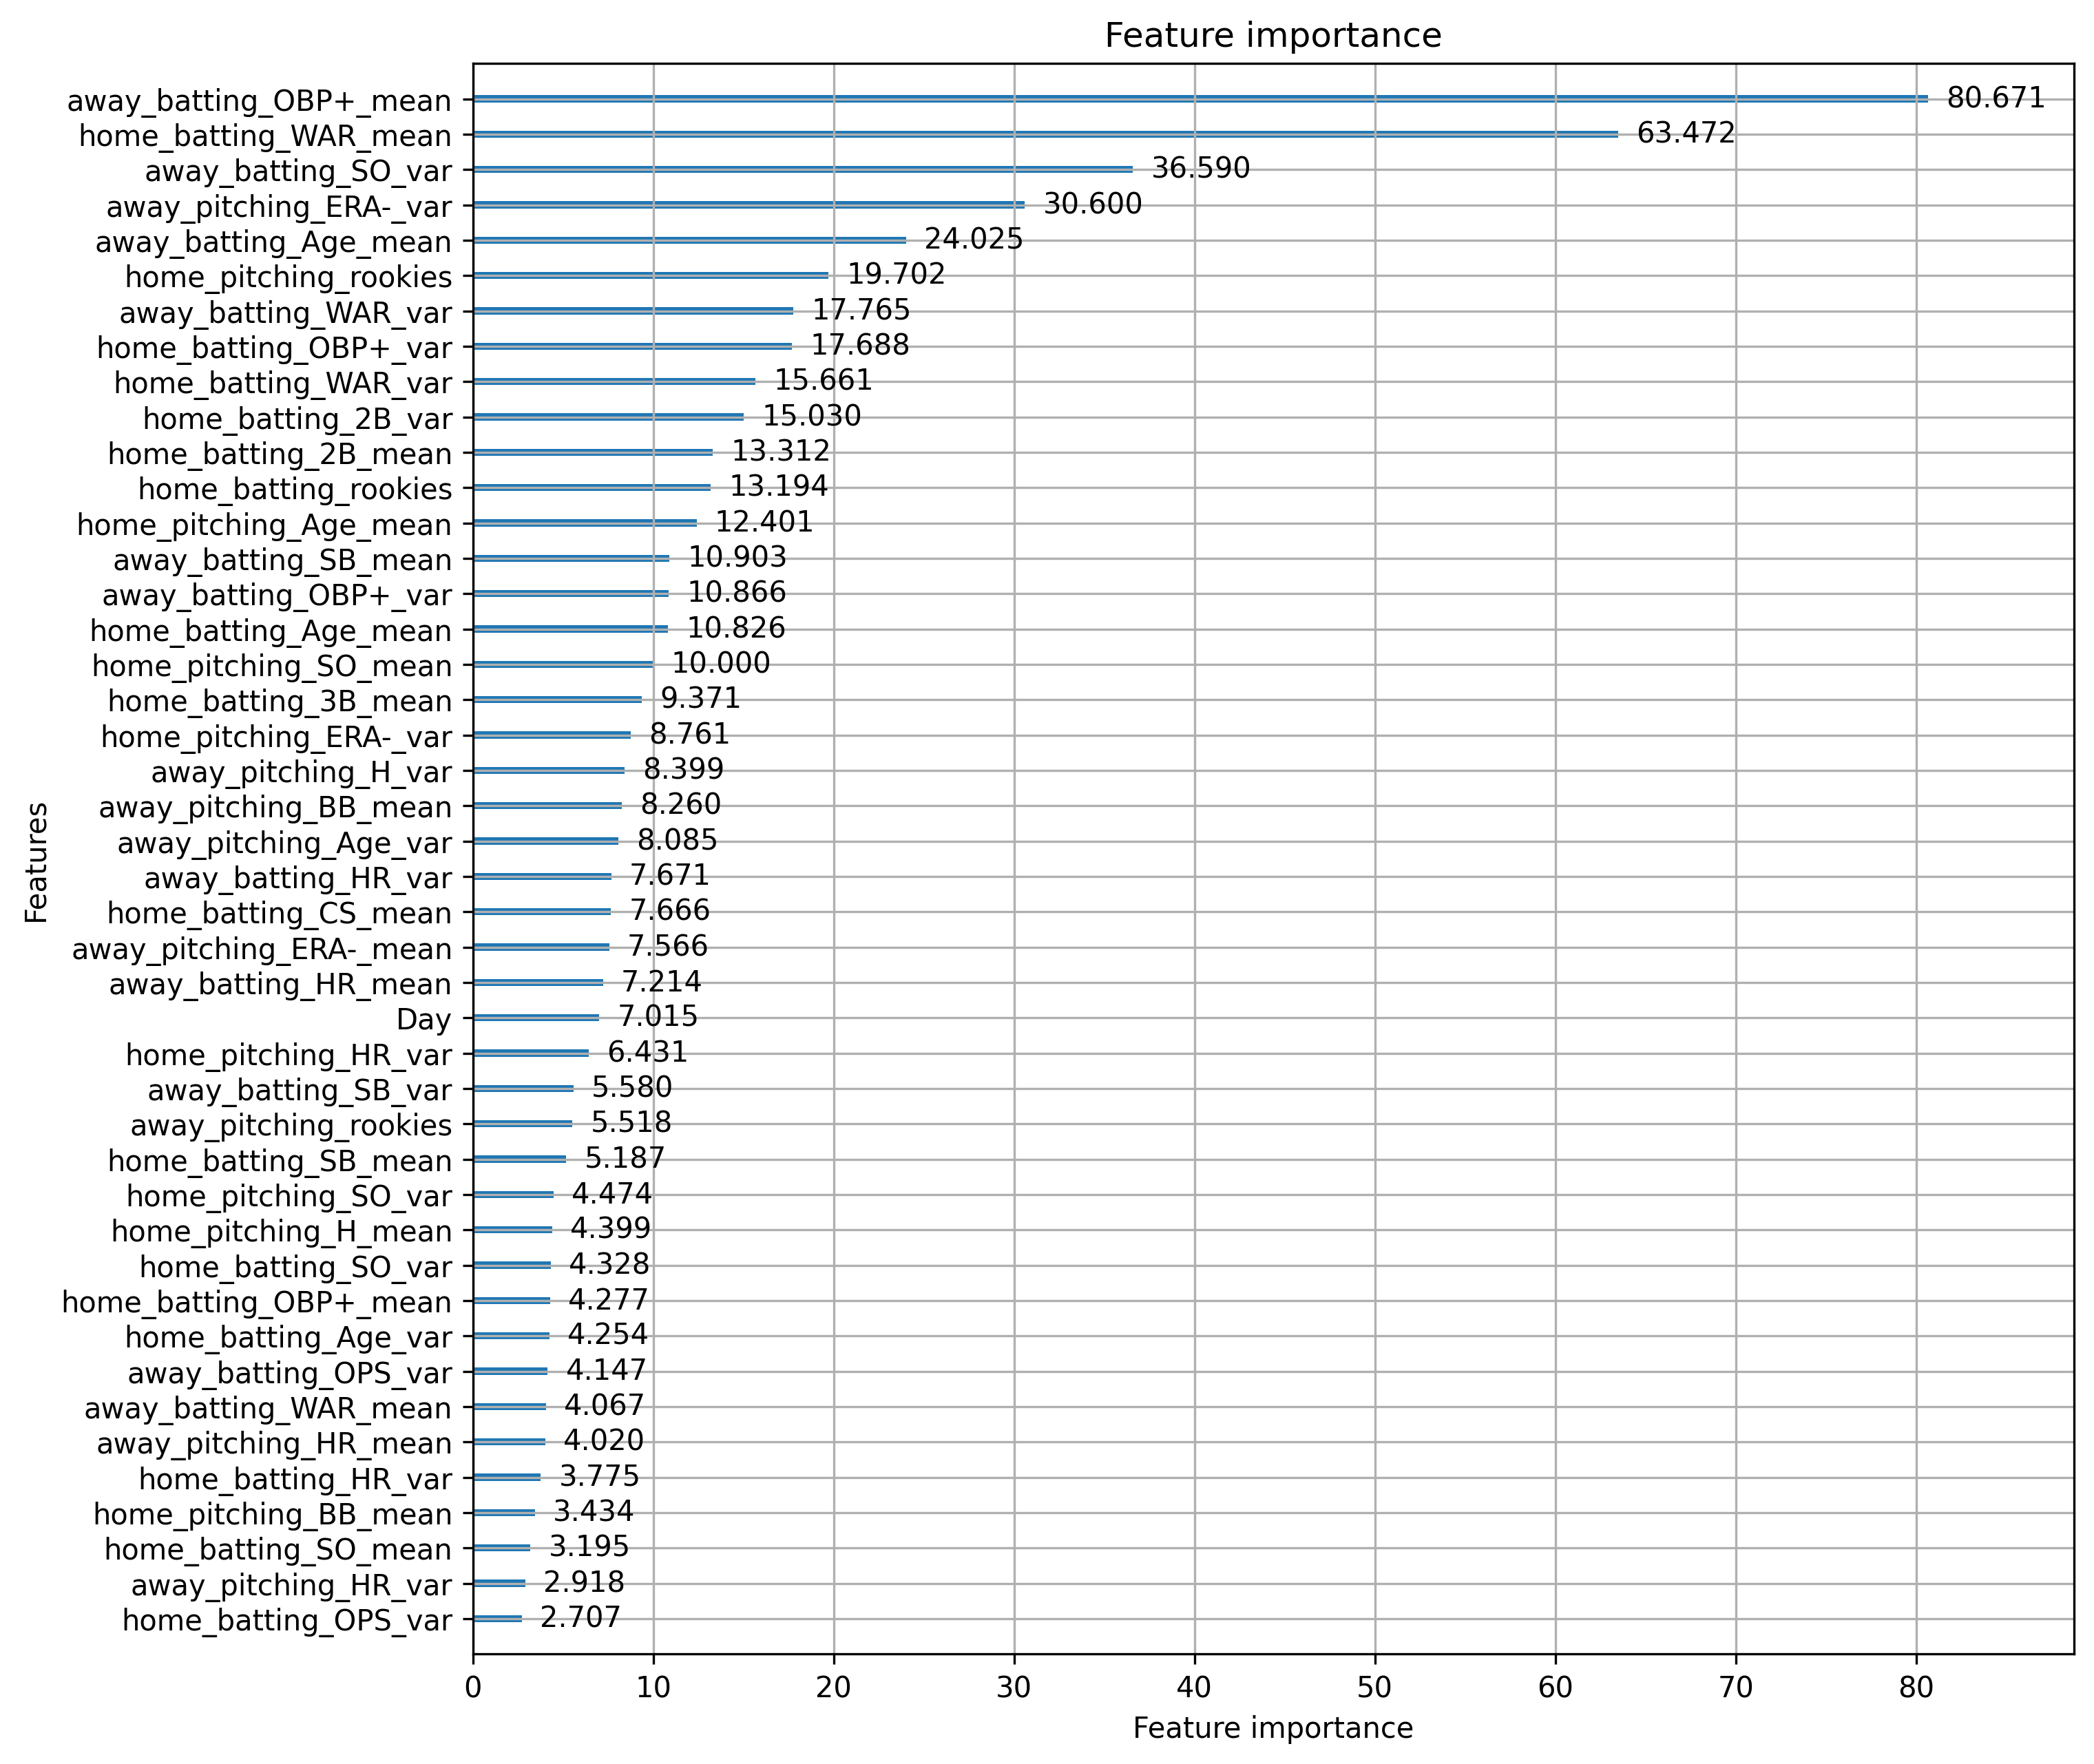

In [367]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(
    {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
    },
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_test,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

lgb.plot_importance(lgb_model, importance_type="gain", figsize=(10, 10))

In [368]:
# LGB Accuracy
acc = best_accuracy(y_test, lgb_model.predict(X_test))
print(f"LGBM Accuracy: {acc*100:.2f}%")

LGBM Accuracy: 60.70%


In [369]:
# Logistic Regression
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {acc*100:.2f}%")

Logistic Regression Accuracy: 55.56%
